In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, f1_score, recall_score, precision_score
)

# 0.1 Load dataset
df = pd.read_csv("/Users/jchatap/Documents/Personal/AI:ML-Certification/Final-Capstone/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv")  
# 0.2 Quick look

print("Shape:", df.shape)
df.info()
df.describe(include="all").T.head(20)



Shape: (101766, 50)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-nu

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,NaN,NaN,NaN,165201645.622978,102640295.983458,12522.0,84961194.0,152388987.0,230270887.5,443867222.0
patient_nbr,101766.0,NaN,NaN,NaN,54330400.694947,38696359.346534,135.0,23413221.0,45505143.0,87545949.75,189502619.0
race,101766,6,Caucasian,76099,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,101766,3,Female,54708,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,101766,10,[70-80),26068,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,101766,10,?,98569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admission_type_id,101766.0,NaN,NaN,NaN,2.024006,1.445403,1.0,1.0,1.0,3.0,8.0
discharge_disposition_id,101766.0,NaN,NaN,NaN,3.715642,5.280166,1.0,1.0,1.0,4.0,28.0
admission_source_id,101766.0,NaN,NaN,NaN,5.754437,4.064081,1.0,1.0,7.0,7.0,25.0
time_in_hospital,101766.0,NaN,NaN,NaN,4.395987,2.985108,1.0,2.0,4.0,6.0,14.0


In [4]:
###Data Cleaning

df = df.copy()

# Replace common missing tokens with actual NaN
df.replace("?", np.nan, inplace=True)

# Count missing per column
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0].head(20)

## Remove duplicates
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Duplicates removed: {before - after}")

### Defining  target .
### binary target: 1 = readmitted within 30 days, else 0.
target_col = "readmitted"

df[target_col].value_counts(dropna=False)

df["readmit_30"] = (df[target_col] == "<30").astype(int)
df["readmit_30"].value_counts(normalize=True)



Duplicates removed: 0


readmit_30
0    0.888401
1    0.111599
Name: proportion, dtype: float64

In [6]:
# Train/test split
# Identify numeric vs categorical
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols]

print("Numeric:", len(numeric_cols))
print("Categorical:", len(categorical_cols))


Numeric: 14
Categorical: 37


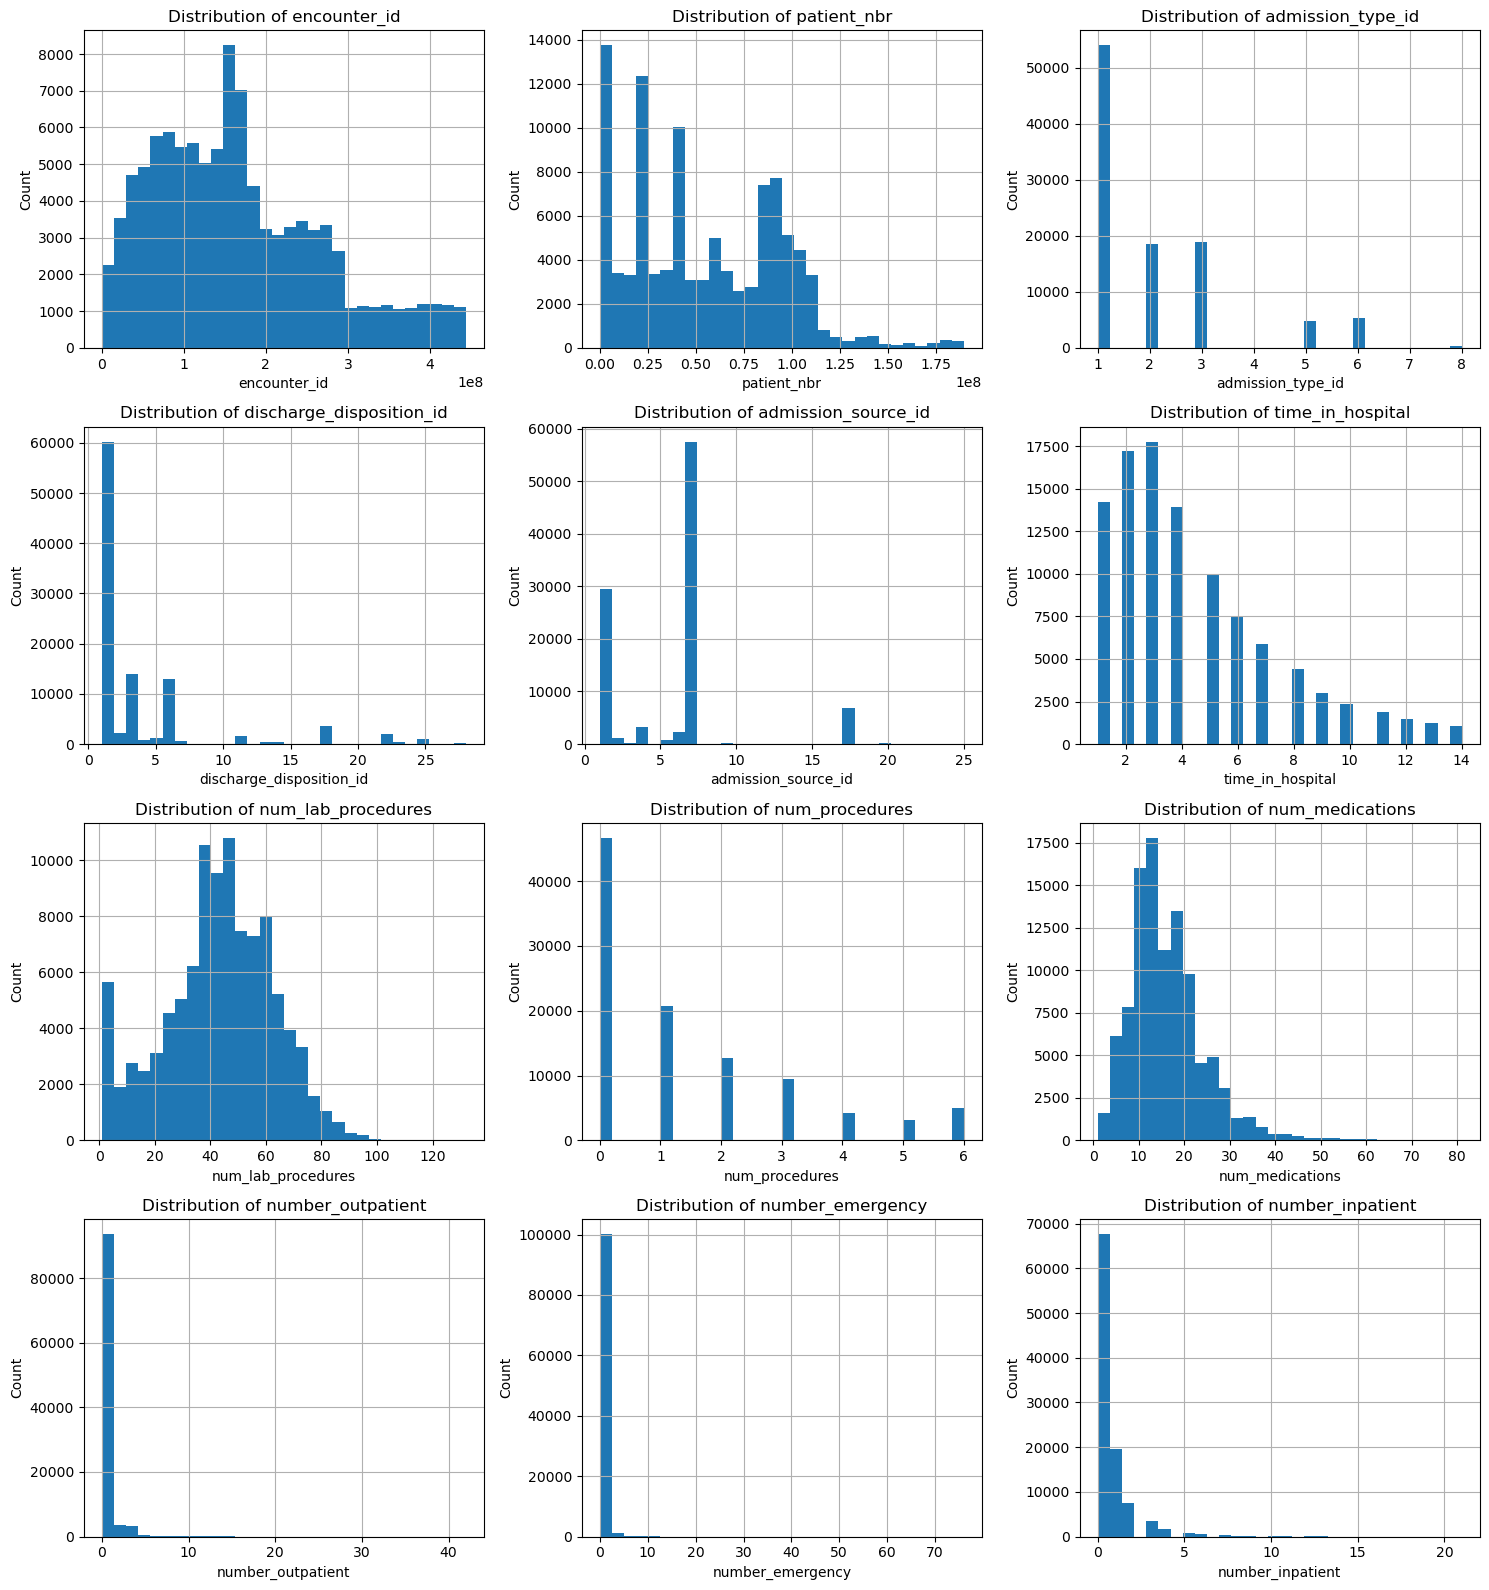

In [8]:
## Visualizations , Plots
## Plot distribution
import matplotlib.pyplot as plt

num_to_plot = [c for c in numeric_cols if c not in ["readmit_30"]]  # avoid plotting target
num_to_plot = num_to_plot[:12]  # keep readable; increase if you want

n = len(num_to_plot)
cols = 3
rows = int(np.ceil(n / cols))

plt.figure(figsize=(cols*5, rows*4))
for i, col in enumerate(num_to_plot, 1):
    ax = plt.subplot(rows, cols, i)
    df[col].hist(bins=30, ax=ax)
    ax.set_title(f"Distribution of {col}", fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()


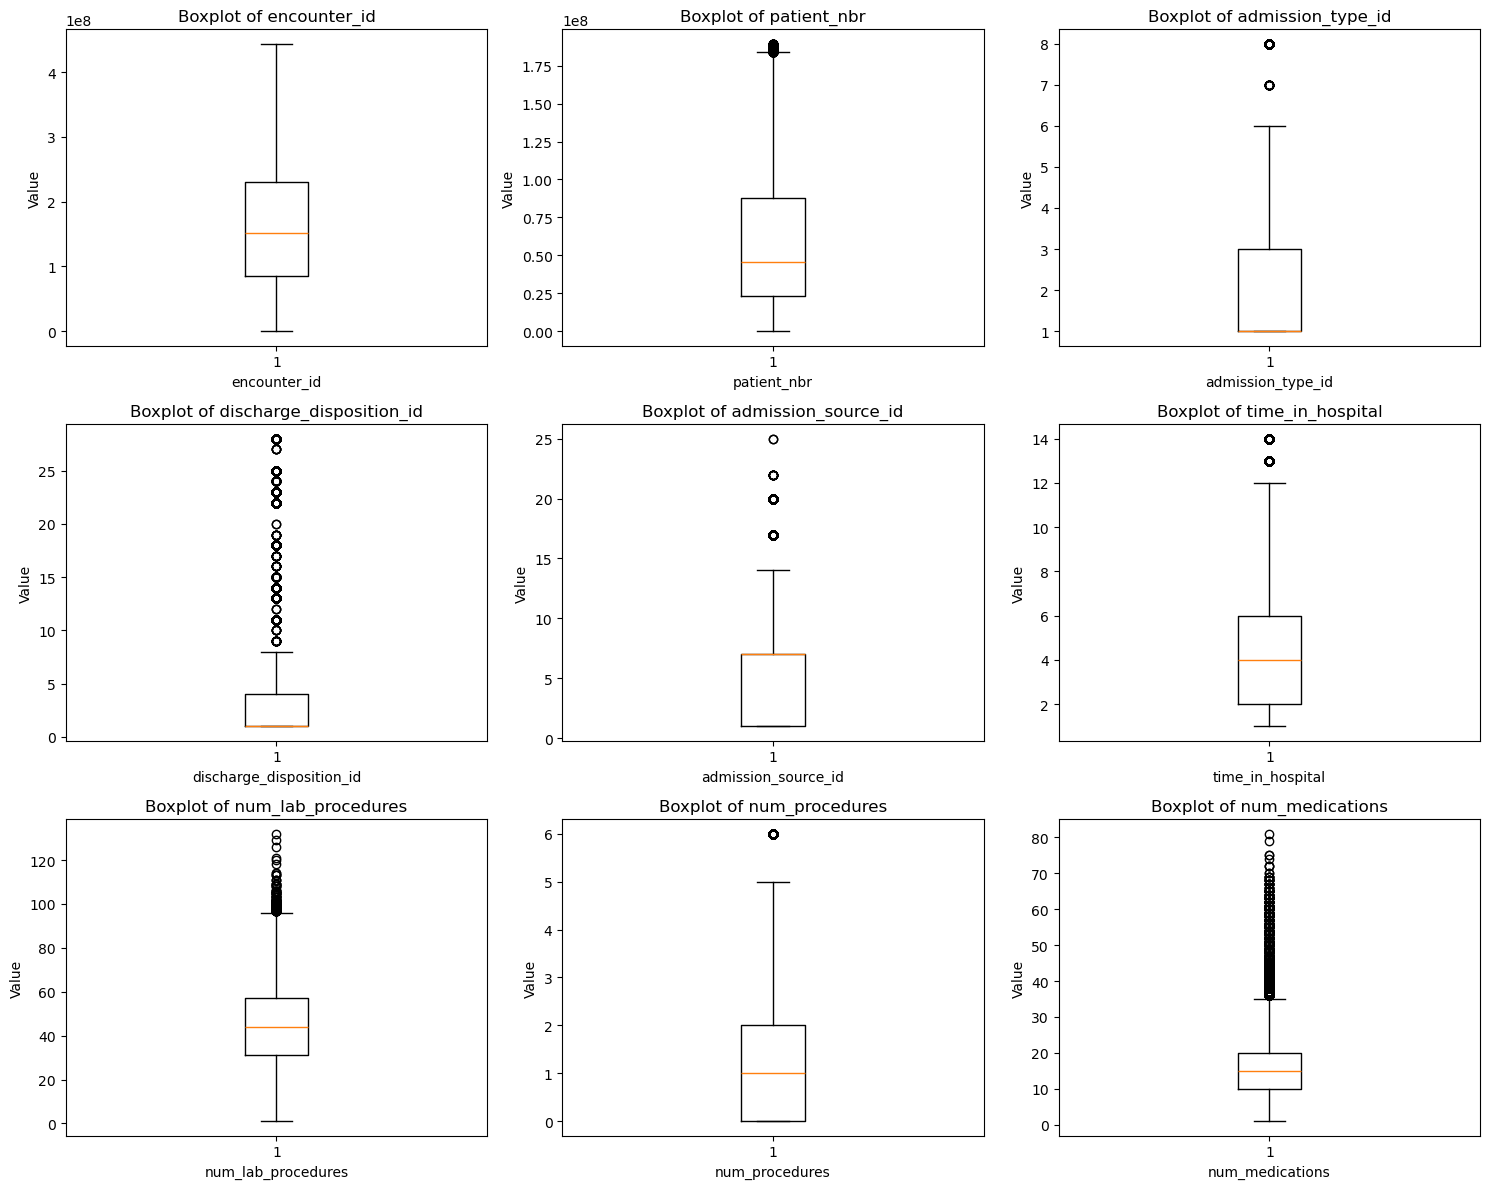

In [10]:
## Boxplots for numeric columns -- For outliers

num_to_plot2 = num_to_plot[:9]
n = len(num_to_plot2)
cols = 3
rows = int(np.ceil(n / cols))

plt.figure(figsize=(cols*5, rows*4))
for i, col in enumerate(num_to_plot2, 1):
    ax = plt.subplot(rows, cols, i)
    ax.boxplot(df[col].dropna(), vert=True)
    ax.set_title(f"Boxplot of {col}", fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel("Value")
plt.tight_layout()
plt.show()


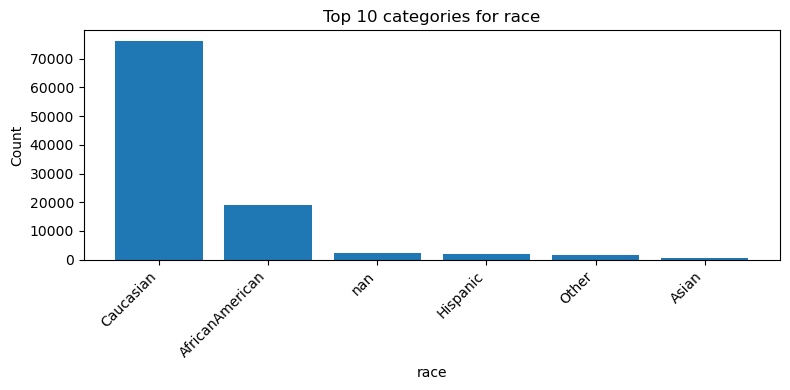

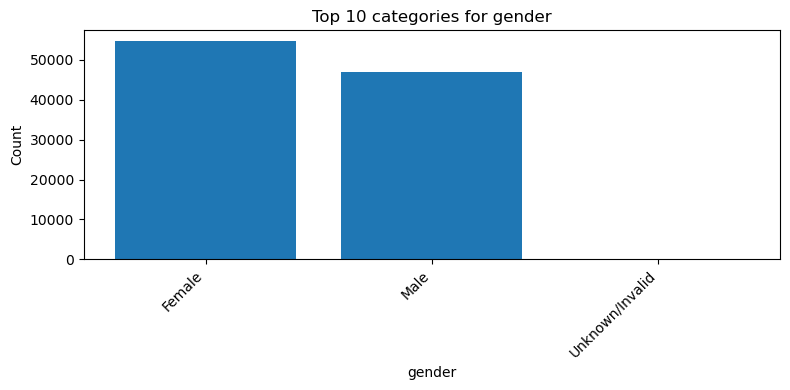

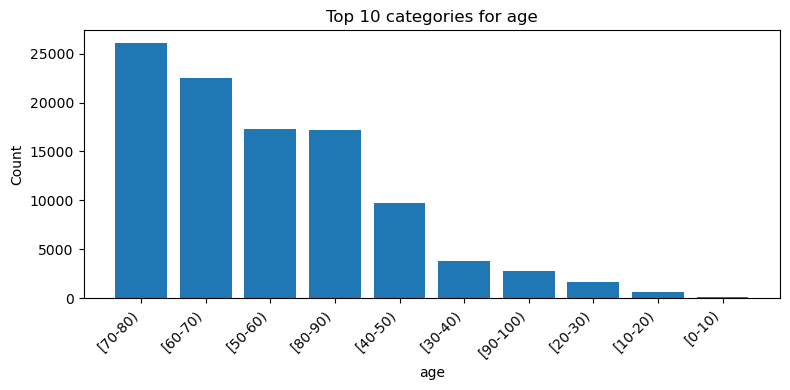

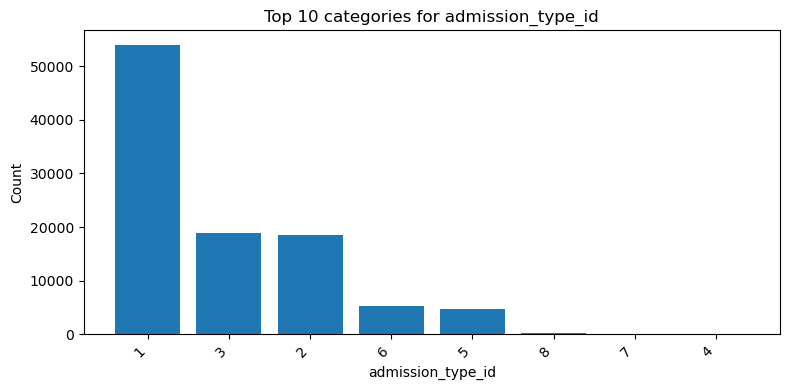

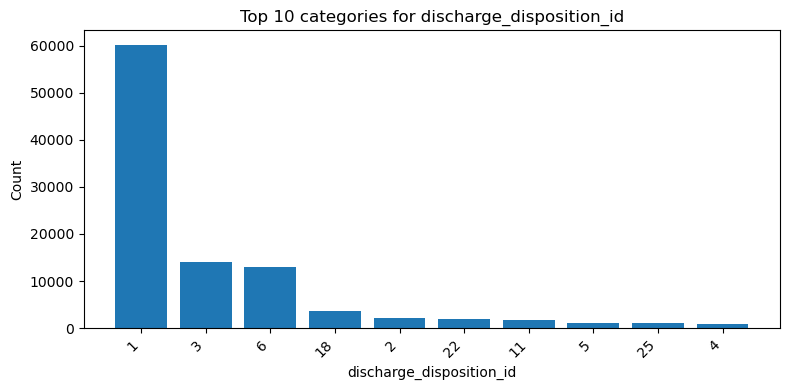

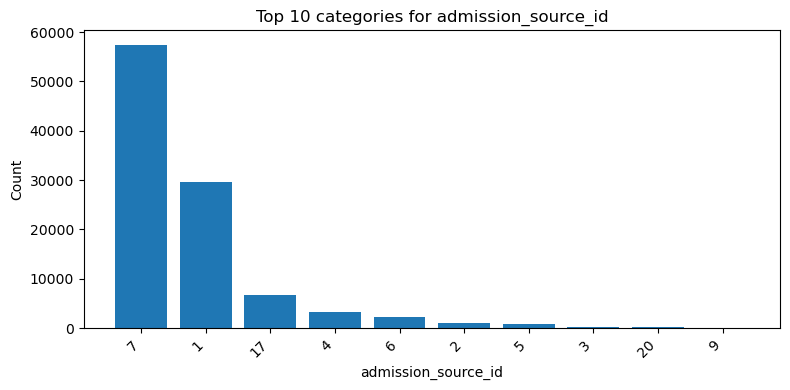

In [12]:
## Categorical counts for top categories
cat_candidates = [c for c in ["race","gender","age","admission_type_id","discharge_disposition_id","admission_source_id"]
                  if c in df.columns]

cat_candidates

def plot_top_categories(df, col, top_n=10):
    vc = df[col].value_counts(dropna=False).head(top_n)
    plt.figure(figsize=(8, 4))
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(f"Top {top_n} categories for {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

for c in cat_candidates:
    plot_top_categories(df, c, top_n=10)



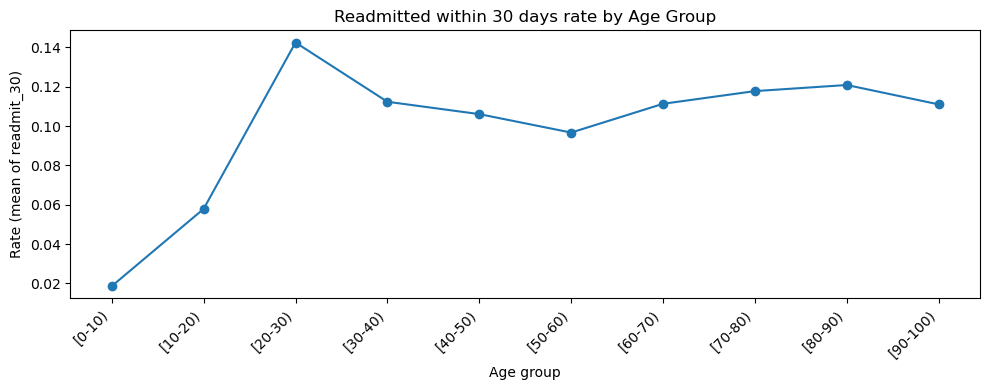

In [14]:
## Target rate by category , readmission within 30 days by age group.

if "age" in df.columns:
    tmp = df.groupby("age")["readmit_30"].mean().sort_index()
    plt.figure(figsize=(10,4))
    plt.plot(tmp.index.astype(str), tmp.values, marker="o")
    plt.title("Readmitted within 30 days rate by Age Group")
    plt.xlabel("Age group")
    plt.ylabel("Rate (mean of readmit_30)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [16]:
###Modeling - Train/test split

from sklearn.model_selection import train_test_split

drop_cols = [c for c in ["encounter_id","patient_nbr", target_col] if c in df.columns]
df_model = df.drop(columns=drop_cols)

X = df_model.drop(columns=["readmit_30"])
y = df_model["readmit_30"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Target rate (train):", y_train.mean(), "Target rate (test):", y_test.mean())


Train: (81412, 47) Test: (20354, 47)
Target rate (train): 0.11160516877118852 Target rate (test): 0.11157512036946055


In [18]:
##Preprocess + baseline Logistic Regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X_train.columns if c not in numeric_features]


numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

clf


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'numbe...
                                                   'max_glu_serum', 'A1Cresult',
                                                   'metformin', 'repaglinide',
                                                   'nateglinide',
                                                   'chlorpropamide',
                                                   'glimepiride',
                                                   'acetohexamide', 'glipizide',
                                                   'glyburide', 'tolbutamide',
                                                   'pioglitazone',
                                                   'rosiglitazone', 'acarbose',
                                                   'miglitol', 'troglitazone',
                                                   'tolazamide', 'examide',
                                                   'citoglipton', 'insulin',
                                                   'glyburide-metformin', ...])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [20]:
##Fit + evaluate
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix

clf.fit(X_train, y_train)

# Predict probabilities for ROC-AUC
y_proba = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)

# Predict labels for F1/confusion matrix (default threshold 0.5)
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred)

print("ROC-AUC:", round(auc, 4))
print("F1:", round(f1, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm


ROC-AUC: 0.6442
F1: 0.2554

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.65      0.76     18083
           1       0.17      0.55      0.26      2271

    accuracy                           0.64     20354
   macro avg       0.54      0.60      0.51     20354
weighted avg       0.84      0.64      0.71     20354



array([[11829,  6254],
       [ 1023,  1248]])

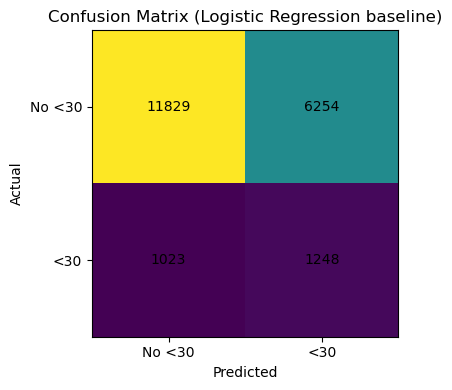

In [22]:
##Confusion matrix plot

import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix (Logistic Regression baseline)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0,1], ["No <30", "<30"])
plt.yticks([0,1], ["No <30", "<30"])

for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, int(val), ha="center", va="center")

plt.tight_layout()
plt.show()


In [26]:
# ==============================
# (Optional) Install XGBoost
# Run this ONCE if xgboost is not installed in your environment
# ==============================

# If you are using Jupyter on your local machine, uncomment and run:
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [28]:
# ==============================
# Multiple Models + Cross-Validation
# ==============================

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

# Try to use XGBoost; fall back to sklearn GradientBoosting if xgboost is unavailable
try:
    from xgboost import XGBClassifier
    has_xgb = True
except Exception as e:
    from sklearn.ensemble import GradientBoostingClassifier
    has_xgb = False
    print("XGBoost not available; using GradientBoostingClassifier instead. Error:", e)

# Primary evaluation metric: ROC-AUC (handles class imbalance well)
scoring = {
    "roc_auc": "roc_auc",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall"
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Build model dictionary (3 model families: linear, bagging, boosting)
models = {
    "LogReg": LogisticRegression(
        solver="saga",
        max_iter=8000,
        class_weight="balanced",
        n_jobs=-1
    ),
    "RandomForest": RandomForestClassifier(
        random_state=42,
        n_estimators=300,
        class_weight="balanced_subsample",
        n_jobs=-1
    )
}

if has_xgb:
    # scale_pos_weight helps handle imbalance: (negative_count / positive_count)
    spw = (y_train.value_counts()[0] / y_train.value_counts()[1])
    models["XGBoost"] = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=float(spw)
    )
else:
    models["GradientBoosting"] = GradientBoostingClassifier(random_state=42)

# Evaluate each model with cross-validation
cv_rows = []
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    scores = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    cv_rows.append({
        "Model": name,
        "ROC-AUC (mean)": scores["test_roc_auc"].mean(),
        "ROC-AUC (std)": scores["test_roc_auc"].std(),
        "F1 (mean)": scores["test_f1"].mean(),
        "Precision (mean)": scores["test_precision"].mean(),
        "Recall (mean)": scores["test_recall"].mean(),
    })

cv_results_df = pd.DataFrame(cv_rows).sort_values("ROC-AUC (mean)", ascending=False)
cv_results_df


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,ROC-AUC (mean),ROC-AUC (std),F1 (mean),Precision (mean),Recall (mean)
2,XGBoost,0.669812,0.003252,0.273372,0.182655,0.543142
1,RandomForest,0.650380,0.006763,0.003728,0.536508,0.001871
0,LogReg,0.630485,0.004518,0.248378,0.162151,0.530486


In [30]:
# ==============================
# Grid Search Hyperparameters (tuning)
# ==============================

from sklearn.model_selection import GridSearchCV

# 1) Logistic Regression Grid Search
pipe_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(solver="saga", max_iter=10000, class_weight="balanced", n_jobs=-1))
])

param_grid_lr = {
    "model__C": [0.1, 0.3, 1.0, 3.0],
    "model__penalty": ["l2"]
}

gs_lr = GridSearchCV(pipe_lr, param_grid_lr, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=1)
gs_lr.fit(X_train, y_train)

print("Best LR CV ROC-AUC:", gs_lr.best_score_)
print("Best LR params:", gs_lr.best_params_)

# 2) Random Forest Grid Search
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced_subsample"))
])

param_grid_rf = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 8, 16],
    "model__min_samples_split": [2, 10],
    "model__min_samples_leaf": [1, 5]
}

gs_rf = GridSearchCV(pipe_rf, param_grid_rf, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)

print("Best RF CV ROC-AUC:", gs_rf.best_score_)
print("Best RF params:", gs_rf.best_params_)

# 3) Boosting Model Grid Search (XGBoost if available; else GradientBoosting)
if has_xgb:
    pipe_xgb = Pipeline(steps=[("preprocess", preprocess), ("model", models["XGBoost"])])
    param_grid_xgb = {
        "model__n_estimators": [300, 500],
        "model__max_depth": [4, 6, 8],
        "model__learning_rate": [0.03, 0.05, 0.1],
        "model__subsample": [0.8, 1.0],
        "model__colsample_bytree": [0.8, 1.0]
    }
    gs_boost = GridSearchCV(pipe_xgb, param_grid_xgb, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=1)
    gs_boost.fit(X_train, y_train)
    print("Best XGB CV ROC-AUC:", gs_boost.best_score_)
    print("Best XGB params:", gs_boost.best_params_)
else:
    pipe_gb = Pipeline(steps=[("preprocess", preprocess), ("model", models["GradientBoosting"])])
    param_grid_gb = {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [2, 3]
    }
    gs_boost = GridSearchCV(pipe_gb, param_grid_gb, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=1)
    gs_boost.fit(X_train, y_train)
    print("Best GB CV ROC-AUC:", gs_boost.best_score_)
    print("Best GB params:", gs_boost.best_params_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best LR CV ROC-AUC: 0.6421028909029556
Best LR params: {'model__C': 0.1, 'model__penalty': 'l2'}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF CV ROC-AUC: 0.6617745210442542
Best RF params: {'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 400}
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best XGB CV ROC-AUC: 0.67346539489678
Best XGB params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.03, 'model__max_depth': 6, 'model__n_estimators': 300, 'model__subsample': 0.8}


In [34]:
# ==============================
# Final Evaluation on Test Set (best tuned model)
# ==============================

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Pick best by cross-validated ROC-AUC
candidates = {
    "LogReg": gs_lr,
    "RandomForest": gs_rf,
    "Boosting": gs_boost
}

best_name, best_gs = max(candidates.items(), key=lambda kv: kv[1].best_score_)
best_model = best_gs.best_estimator_

best_model.fit(X_train, y_train)

# Probabilities for ROC-AUC
if hasattr(best_model.named_steps["model"], "predict_proba"):
    y_proba = best_model.predict_proba(X_test)[:, 1]
else:
    # Some models might expose decision_function instead
    y_proba = best_model.decision_function(X_test)

y_pred = best_model.predict(X_test)

print("Selected best model:", best_name)
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Test F1:", f1_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:", cm)



Selected best model: Boosting
Test ROC-AUC: 0.6855207601973706
Test F1: 0.28086164043082024
Test Precision: 0.1836154366960054
Test Recall: 0.5970937912813739
Classification Report:               precision    recall  f1-score   support

           0       0.93      0.67      0.78     18083
           1       0.18      0.60      0.28      2271

    accuracy                           0.66     20354
   macro avg       0.56      0.63      0.53     20354
weighted avg       0.85      0.66      0.72     20354

Confusion Matrix: [[12054  6029]
 [  915  1356]]


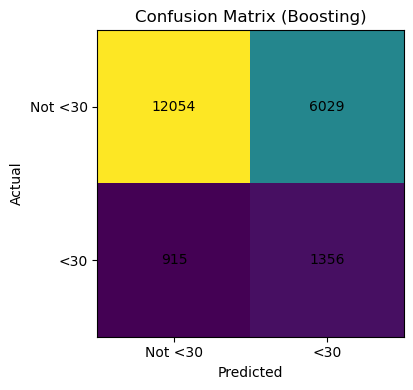

In [36]:
# ==============================
# Confusion Matrix Plot (best model)
# ==============================

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title(f"Confusion Matrix ({best_name})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0,1], ["Not <30", "<30"])
plt.yticks([0,1], ["Not <30", "<30"])

for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, int(val), ha="center", va="center")

plt.tight_layout()
plt.show()


In [50]:
# ==============================
# Model Interpretation
# - Logistic Regression: coefficients / odds ratios
# - Tree/Boosting: permutation importance (model-agnostic)
# ==============================

import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance


if best_name == "LogReg":
    # Build feature names after preprocessing
    ohe = best_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
    cat_feature_names = ohe.get_feature_names_out(cat_cols)
    
    # Make sure num_cols is a numpy array for proper concatenation
    num_cols_array = np.array(num_cols)
    
    # Get the actual coefficients to determine the correct length
    coefs = best_model.named_steps["model"].coef_.ravel()
    
    # Debug the lengths to ensure they match
    print(f"Number of coefficients: {len(coefs)}")
    print(f"Number of numeric features: {len(num_cols_array)}")
    print(f"Number of categorical features after OHE: {len(cat_feature_names)}")
    
    # Create feature names that match the coefficient length
    if len(num_cols_array) + len(cat_feature_names) == len(coefs):
        feature_names = np.concatenate([num_cols_array, cat_feature_names])
    else:
        # If lengths don't match, create generic feature names
        feature_names = np.array([f"feature_{i}" for i in range(len(coefs))])
        print("Warning: Feature names don't match coefficient length. Using generic names.")

    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coef": coefs,
        "odds_ratio": np.exp(coefs)
    }).sort_values("coef", ascending=False)

    print("Top features increasing readmission risk:")
    display(coef_df.head(15))

    print("Top features decreasing readmission risk:")
    display(coef_df.tail(15))

# For permutation importance, we need to ensure we have the correct feature names
try:
    # Permutation importance works for any fitted pipeline
    perm = permutation_importance(
        best_model, X_test, y_test,
        n_repeats=5, random_state=42,
        scoring="roc_auc", n_jobs=-1
    )

    # Get the actual number of features in the model
    n_features = perm.importances_mean.shape[0]
    
    # Try to get feature names that match the number of features
    ohe = best_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
    cat_feature_names = ohe.get_feature_names_out(cat_cols)
    
    if len(num_cols) + len(cat_feature_names) == n_features:
        feature_names = np.concatenate([np.array(num_cols), cat_feature_names])
    else:
        # If lengths don't match, create generic feature names
        feature_names = np.array([f"feature_{i}" for i in range(n_features)])
        print("Warning: Feature names don't match permutation importance length. Using generic names.")

    imp_df = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    }).sort_values("importance_mean", ascending=False)

    print("Top 20 features by permutation importance (ROC-AUC drop):")
    display(imp_df.head(20))
    
except Exception as e:
    print(f"Error in permutation importance calculation: {e}")

Top 20 features by permutation importance (ROC-AUC drop):


,feature,importance_mean,importance_std
15,feature_15,0.070357,0.003092
5,feature_5,0.053872,0.002963
16,feature_16,0.007630,0.001505
7,feature_7,0.003058,0.000746
18,feature_18,0.002818,0.001364
46,feature_46,0.002328,0.000172
14,feature_14,0.002322,0.000472
9,feature_9,0.002175,0.001519
8,feature_8,0.002114,0.000708
2,feature_2,0.001871,0.000127
